<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Exploratory-Data-Analysis-and-Metric" data-toc-modified-id="Exploratory-Data-Analysis-and-Metric-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Exploratory Data Analysis and Metric</a></span></li><li><span><a href="#Model" data-toc-modified-id="Model-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Model</a></span></li><li><span><a href="#Submit" data-toc-modified-id="Submit-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Submit</a></span></li><li><span><a href="#Homework" data-toc-modified-id="Homework-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Homework</a></span></li></ul></div>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')

from sklearn.preprocessing  import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import balanced_accuracy_score

In [2]:
SEED = 42

Удалила данные из репозитория, так как они слишком большие чтобы залить их на гитхаб

In [3]:
DATA_PATH = './data/language-detection'

In [4]:
pd.set_option('display.max_rows', 315)


**[Kaggle InClass: Language Detection](https://www.kaggle.com/t/bb11ace54b1a465e91b8c3f46a840ce0)**

# Exploratory Data Analysis and Metric

In [5]:
train_df = pd.read_csv(f'{DATA_PATH}/train/train.csv')
test_df = pd.read_csv(f'{DATA_PATH}/test/test.csv')

In [6]:
train_df.shape, test_df.shape

((3159633, 2), (2784634, 2))

In [7]:
drop1 = train_df.loc[(train_df['language'] == 'vi') & (train_df['sentence'].str.find('笑') != -1)]

In [8]:
train_df = train_df.drop(drop1.index)

In [9]:
train_df.shape

(3134633, 2)

In [10]:
drop2 = train_df.loc[(train_df['language'] == 'ru') & (train_df['sentence'].str.find('і') != -1)]

In [11]:
drop2.shape

(75000, 2)

In [12]:
train_df = train_df.drop(drop2.index)

In [13]:
drop3 = train_df.loc[(train_df['language'] == 'en') & (train_df['sentence'].str.match('[а-яА-ЯёЁ]+'))]

In [14]:
train_df = train_df.drop(drop3.index)

In [15]:
drop4 = train_df.loc[(train_df['language'] == 'fr') & (train_df['sentence'].str.match('[а-яА-ЯёЁ]+'))]

In [16]:
train_df = train_df.drop(drop4.index)

In [17]:
drop5 = train_df.loc[(train_df['language'] == 'th') & (train_df['sentence'].str.match('[а-яА-ЯёЁ]+'))]

In [18]:
train_df = train_df.drop(drop5.index)

In [19]:
drop6 = train_df.loc[(train_df['language'] == 'th') & (train_df['sentence'].str.find('笑') != -1)]

In [20]:
train_df = train_df.drop(drop6.index)

In [21]:
drop7 = train_df.loc[(train_df['language'] == 'et') & (train_df['sentence'].str.match('[а-яА-ЯёЁ]+'))]

In [22]:
train_df = train_df.drop(drop7.index)

In [23]:
drop8 = train_df.loc[(train_df['language'] == 'ku') & (train_df['sentence'].str.match('[а-яА-ЯёЁ]+'))]

In [24]:
train_df.shape

(2884633, 2)

In [25]:
train_df = train_df.drop(drop8.index)

In [26]:
train_df.shape

(2834633, 2)

In [27]:
drop9 = train_df.loc[(train_df['language'] == 'ta') & (train_df['sentence'].str.find('the and of it that you to apos we this') != -1)]

In [28]:
train_df = train_df.drop(drop9.index)

In [29]:
lang_count = (
    train_df.language.value_counts()
    .to_frame()
    .reset_index()
)

lang_count.head()

,index,language
0,en,132655
1,ar,110032
2,he,108663
3,ru,106970
4,ko,105638


Удалила примеси кириллических языков и китайского из датасетов. Далее буду чистить сербский язык, так как в нем понамешен как минимум хорватский в большом количестве

In [30]:
train_df.loc[train_df['sentence'].str.find('笑') != -1]['language'].unique()

array(['ja', 'zh-cn', 'zh-tw', 'zh'], dtype=object)

In [31]:
train_df.loc[train_df['sentence'].str.match('[а-яА-ЯёЁ]+')]['language'].unique()

array(['ru', 'bg', 'uk', 'sr', 'mn', 'mk', 'be', 'kk', 'es'], dtype=object)

In [32]:
sr = train_df.loc[(train_df['language'] == 'sr')]
nodrop = train_df.loc[(train_df['language'] == 'sr') & train_df['sentence'].str.match('[а-яА-ЯЂђЈјКкЉљЊњЋћЏџ ().,]+')]
drop11 = sr.drop(nodrop.index)
train_df = train_df.drop(drop11.index)

In [33]:
lang_count = (
    train_df.language.value_counts()
    .to_frame()
    .reset_index()
)

lang_count.head()

,index,language
0,en,132655
1,ar,110032
2,he,108663
3,ru,106970
4,ko,105638


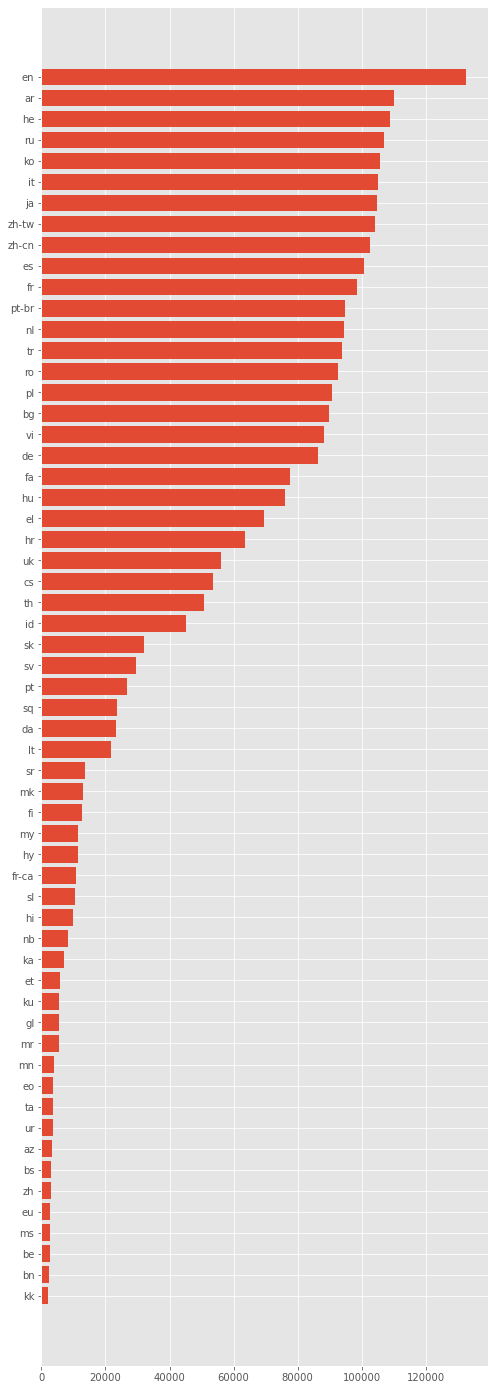

In [34]:
fig, ax = plt.subplots(figsize=(8,25))

ax.barh(lang_count['index'], lang_count['language'])
ax.invert_yaxis();

In [35]:
lang_count[lang_count['index'].apply(lambda x: x in {"en", "kk"})]

,index,language
0,en,132655
58,kk,2046


Датасет сильно не сбалансирован по классам, а требуется хорошее качество для всех языков, поэтому метрика в данном соревновании — взвешенная доля правильных ответов:

$$ 
\text{WeightedAccuracy}\left(y, \hat{y}, w\right) = \frac{\displaystyle{\sum_{i=1}^{n}} w_i \cdot \left(y_i == \hat{y}_i\right)}{\displaystyle\sum_{i=1}^{n} w_i } 
$$

Веса выбирались обратно пропорционально количеству примеров соответствующего языка:
$$
w\left(\text{"en"}\right) \sim \frac{1}{157655}
$$
$$ \dots $$
$$
w\left(\text{"kk"}\right) \sim \frac{1}{2046}
$$

Поэтому для валидации можно использовать [sklearn.metrics.balanced_accuracy_score](https://scikit-learn.org/stable/modules/model_evaluation.html#balanced-accuracy-score)

# Model

In [37]:
x = train_df.values[:, 0]
label_encoder = LabelEncoder().fit(train_df.values[:, 1])
y = label_encoder.transform(train_df.values[:, 1])

In [38]:
pipe = Pipeline([
    ('vectorizer', TfidfVectorizer(lowercase=True, ngram_range=(4, 4), analyzer='char')),
    ('model', SGDClassifier(random_state=SEED, loss='modified_huber', class_weight='balanced'))
])

In [39]:
pipe.fit(x, y)

Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(analyzer='char', ngram_range=(4, 4))),
                ('model',
                 SGDClassifier(class_weight='balanced', loss='modified_huber',
                               random_state=42))])

In [40]:
predictions = pipe.predict(x)

In [41]:
balanced_accuracy_score(y, predictions)

0.9342803333236771

# Submit

In [42]:
submit_predictions = pipe.predict(test_df.sentence.values)

In [43]:
test_df['language'] = label_encoder.classes_[submit_predictions]

test_df.head()

,index,sentence,language
0,0,תודה לכם .,he
1,1,"Precisamos de compaixão para começar , e auto-...",pt-br
2,2,這個增長相當大 ， 並且它將引發經濟的增長 。,zh-tw
3,3,시애틀에서 자란 제가 처음 가난을 보게 되던 때를 기억해요 .,ko
4,4,これをロボットに組み込みました,ja


In [44]:
(
    test_df[['index', 'language']]
    .to_csv(f'{DATA_PATH}/sample_submission.csv', index=False)
)

In [45]:
!head $DATA_PATH/sample_submission.csv

index,language
0,he
1,pt-br
2,zh-tw
3,ko
4,ja
5,zh-tw
6,hu
7,nl
8,ru


# Homework

- выбить хороший score на private leaderboard'е (8 баллов)
- совет: поищите ошибки в train-части датасета